In [32]:
import gym 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import torch
from torch.nn import Sequential, Linear, ReLU, Module
from tqdm.notebook import tqdm_notebook
from torch.optim import Adam
import math 
import random
from torch.nn.functional import mse_loss
import torch.nn.functional as F
import itertools
from torch.distributions import Categorical

In [27]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple

## n-step A2C (Advantage actor critic)

In [28]:
class ActorNetwork(torch.nn.Module):

    def __init__(self,input_size,hidden_size,action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size,hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size,hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size,action_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out))
        return out

In [29]:
class ValueNetwork(torch.nn.Module):

    def __init__(self,input_size,hidden_size,output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size,hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size,hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size,output_size)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [30]:
dev = torch.device('cuda')
hidden_size = 20
critic = ValueNetwork(4, hidden_size, 1).to(dev)
actor = ActorNetwork(4, hidden_size, 2).to(dev)

In [31]:
n_episodes = 1000
lr = 1e-3
gamma = 0.99
n_steps = 10

env = gym.make('CartPole-v0')

opt_critic = Adam(critic.parameters(), lr=lr)
opt_actor = Adam(actor.parameters(), lr=lr)

f_rewards = []

for i in tqdm_notebook(range(n_episodes)) :
    done = False
    acc_reward  = 0
    observation_b = torch.tensor([env.reset()] , dtype=torch.float, device=dev)
    count = 1
    
    rewards = []
    critic_values = []
    log_probs = []
    
    while not done :
        
        critic_val = critic(observation_b).view(-1)
        critic_values.append(critic_val)
        
        actions_probs = actor(observation_b)
        distribution = Categorical(actions_probs)
        action = distribution.sample()
        log_probs.append(distribution.log_prob(action))
        
        observation_a, reward, done, _ = env.step(action.detach().item())
        observation_a = torch.tensor([observation_a] , dtype=torch.float, device=dev)
        rewards.append(reward)
        
        acc_reward += reward
        
        if count % n_steps == 0 or done :
            q_vals = np.zeros((len(rewards), 1))
            with torch.no_grad() :
                q_val = critic(observation_a).cpu().detach().data.numpy() * (1-done)
            for i, r in enumerate(reversed(rewards)) :
                q_val = r + gamma * q_val
                q_vals[len(rewards)-1-i] = q_val
            advantage = torch.tensor(q_vals, device=dev) - torch.stack(critic_values)
            opt_actor.zero_grad()
            opt_critic.zero_grad()
            critic_loss = advantage.pow(2).mean()
            critic_loss.backward()
            opt_critic.step()
            actor_loss = -(torch.stack(log_probs)*advantage.detach()).mean()
            actor_loss.backward()
            opt_actor.step()
            
            rewards.clear()
            critic_values.clear()
            log_probs.clear()
            
            
            
        
        
        count += 1
        observation_b = observation_a

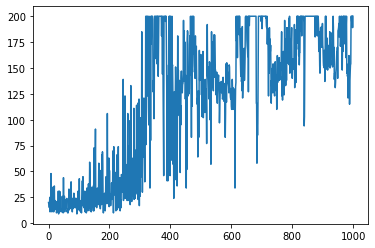

In [33]:
plt.plot(range(len(f_rewards)), f_rewards)

In [34]:
rewards_avg = np.convolve(f_rewards, np.ones((100,))/100, mode='valid')

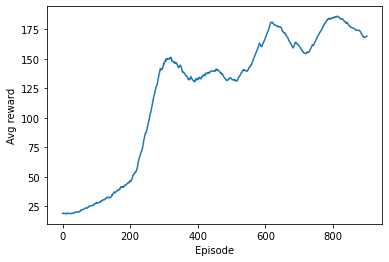

In [35]:
plt.plot(range(len(rewards_avg)), rewards_avg)
plt.xlabel('Episode')
plt.ylabel('Avg reward')
plt.show()